In [16]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from neuralnet import NeuralNetMLP

In [2]:
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2 # mnist 픽셀을 -1 ~ 1 사이로 정규화

    return images, labels

In [6]:
X_train, y_train = load_mnist('dataset', kind='train')

In [7]:
print('train 행: %d, 열: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('dataset', kind='t10k')
print('test 행: %d, 열: %d' % (X_test.shape[0], X_test.shape[1]))

train 행: 60000, 열: 784
test 행: 10000, 열: 784


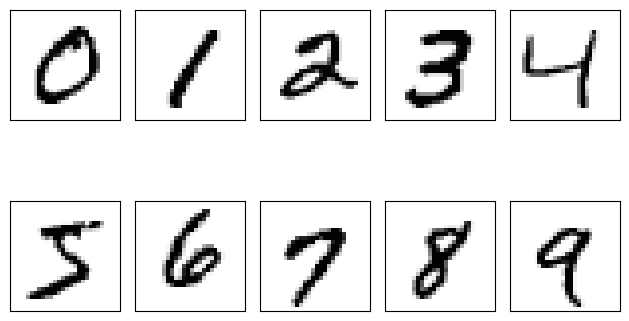

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28) # label이 i인 이미지 중 첫번째 이미지
    ax[i].imshow(img, cmap='Greys') # 흑백 이미지
ax[0].set_xticks([]) # x축 눈금
ax[0].set_yticks([]) # y축 눈금
plt.tight_layout() # subplot 간 간격 자동 조절
plt.show()

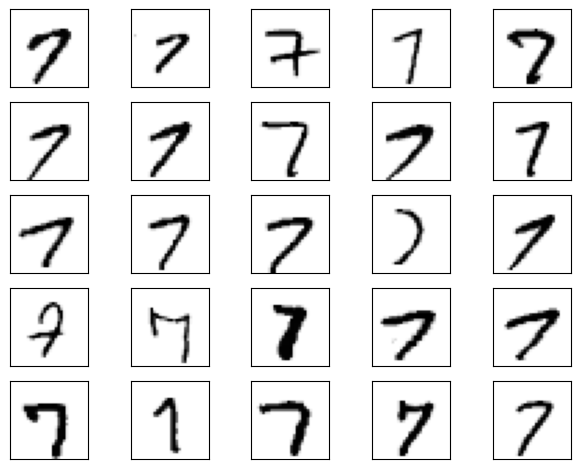

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28) # label이 7인 이미지 25개
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


이후 스케일 된 이미지를 새로운 파이썬 세션에서 빠르게 읽을 수 있게 포맷으로 저장하는 것이 좋다.
이때, 다차원 배열을 디스크에 저장하는 좋은 방법은 'savez' 함수를 사용하는 것이다.

In [11]:
np.savez_compressed('dataset/mnist_scaled.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test) # 저장

In [12]:
mnist = np.load('dataset/mnist_scaled.npz') # 불러오기

In [13]:
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [14]:
X_train = mnist['X_train']

In [15]:
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

In [17]:
nn = NeuralNetMLP(n_hidden=100, l2=0.01, epochs=200, eta=0.0005, minibatch_size=100, shuffle=True, seed=1)

In [18]:
nn.fit(X_train=X_train[:55000], y_train=y_train[:55000], X_valid=X_train[55000:], y_valid=y_train[55000:])

200/200 | 비용: 5065.78 | 훈련/검증 정확도: 99.28%/97.98%  

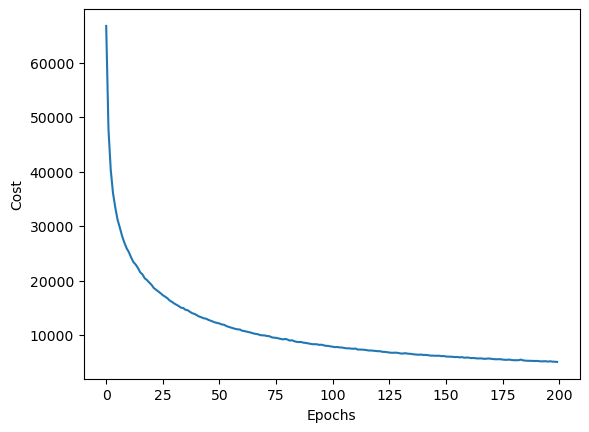

In [19]:
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

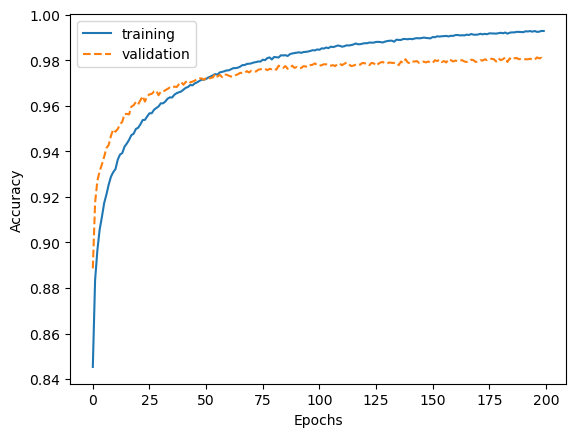

In [20]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [22]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred) / X_test.shape[0])
print('테스트 정확도: %.2f%%' % (acc * 100))

테스트 정확도: 97.54%


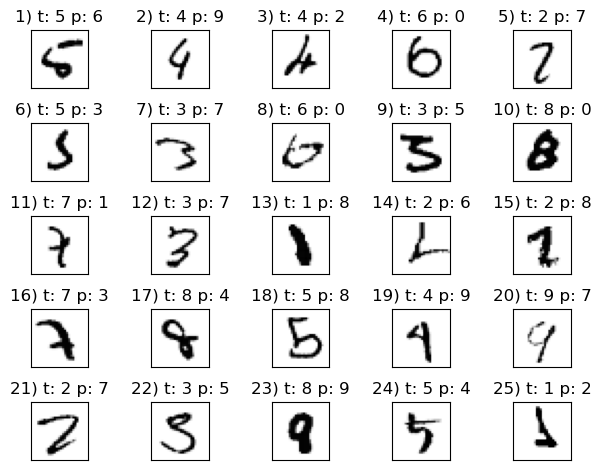

In [23]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()